----
# Comparison of NES-OP and PINNeik on Marmousi model
----
Open in [Colab](https://colab.research.google.com/github/sgrubas/NES/blob/main/notebooks/PINNeik_NES-OP_Marmousi.ipynb)

In [ ]:
!pip install sciann==0.5.4.0 # for PINNeik
!pip install eikonalfm # for reference solution (2nd-order factored FMM)
!pip install git+https://github.com/sgrubas/NES.git # Neural Eikonal Solver

from IPython.display import clear_output
clear_output()   

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback # progress bar
from eikonalfm import factored_fast_marching as ffm # reference solution
from eikonalfm import distance # reference solution
import NES # Neural Eikonal Solver
import sciann # for PINNeik
import holoviews as hv # for visualization
hv.extension('matplotlib')

# Uploading velocity model
---

In [ ]:
Vel = NES.misc.Marmousi(smooth=3, section=[[600, 881], None]) # importing from NES package data
vmin, vmax = Vel.min, Vel.max
xmin, zmin = Vel.xmin
xmax, zmax = Vel.xmax
x = np.linspace(xmin, xmax, 281)
z = np.linspace(zmin, zmax, 281)
dx, dz = x[1]-x[0], z[1]-z[0]
X, Z = np.meshgrid(x, z, indexing='ij')
Xr = np.stack([X, Z], axis=-1) # collocation points 

nx, nz = len(x), len(z)
V = Vel(Xr)

# Reference solution - second-order factored FMM
___
For details see [github source](https://github.com/kevinganster/eikonalfm)

In [ ]:
# Point-source location
ixs = (nx//2, nz//2)
xs = Xr[ixs]
print(xs)

[1.75625 1.75625]


In [ ]:
%%time
D = distance(V.shape, [dx, dz], ixs, indexing='ij')
T_ref = D * ffm(V, ixs, [dx, dz], 2)

CPU times: user 41.4 ms, sys: 0 ns, total: 41.4 ms
Wall time: 42.5 ms


# NES-OP solution
---
For details see [paper](https://arxiv.org/abs/2205.07989)

In [ ]:
NES_OP = NES.NES_OP(xs=xs, velocity=Vel)
NES_OP.build_model()

In [ ]:
%%time
h = NES_OP.train(x_train=Xr, 
             batch_size=int(nx*nz/4),
             epochs=5000, verbose=0,
             callbacks=[TqdmCallback(verbose=0, miniters=50)])

0epoch [00:00, ?epoch/s]

CPU times: user 2min 9s, sys: 4.92 s, total: 2min 13s
Wall time: 1min 54s


In [ ]:
NES_loss = h.history['loss']
T_nes = NES_OP.Traveltime(Xr)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


# PINNeik solution
---
For details on PINNeik see [paper](https://arxiv.org/pdf/2007.08330.pdf) 

Code was copied and adapted from https://github.com/umairbinwaheed/PINNeikonal/blob/main/codes/script1.ipynb

In [ ]:
# Number of training points
num_tr_pts = nx*nz - 1

# Grid points for prediction 
X_star = Xr.reshape(-1, Xr.shape[-1]) 

selected_pts = np.random.choice(np.arange(nx*nz), num_tr_pts, replace=False)
X_starf = np.vstack((X_star[selected_pts], xs))  # Grid points for training

vs = V[ixs] # Velocity at the source location
sx, sz = xs
T0 = np.sqrt((X-sx)**2 + (Z-sz)**2)/vs; 

px0 = np.divide(X-sx, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

# Find source location id in X_starf
TOL = 1e-6
R_starf = np.linalg.norm(X_starf - xs[None, ...], axis=-1)
sids = np.argwhere(R_starf < TOL).squeeze()
print(sids)
print(sids.shape)
print(X_starf[sids])

[57665 78960]
(2,)
[[1.75625 1.75625]
 [1.75625 1.75625]]


In [ ]:
# Preparing the Sciann model object

tf.keras.backend.clear_session() 
layers = [20]*10 
# Appending source values
velmodelf = V.reshape(-1,1)[selected_pts]; 
velmodelf = np.append(velmodelf, vs)
px0f = px0.reshape(-1,1)[selected_pts]; px0f = np.append(px0f,0.)
pz0f = pz0.reshape(-1,1)[selected_pts]; pz0f = np.append(pz0f,0.)
T0f = T0.reshape(-1,1)[selected_pts]; T0f = np.append(T0f,0.)

xt = sciann.Variable("xt",dtype='float64')
zt = sciann.Variable("zt",dtype='float64')
vt = sciann.Variable("vt",dtype='float64')
px0t = sciann.Variable("px0t",dtype='float64')
pz0t = sciann.Variable("pz0t",dtype='float64')
T0t = sciann.Variable("T0t",dtype='float64')

PINNeik_tau = sciann.Functional("tau", [xt, zt], layers, 'l-atan')

# Loss function based on the factored isotropic eikonal equation
L = ((T0t * sciann.utils.diff(PINNeik_tau, xt) + PINNeik_tau*px0t)**2 + 
     (T0t * sciann.utils.diff(PINNeik_tau, zt) + PINNeik_tau*pz0t)**2 - 1.0/vt**2)

targets = [PINNeik_tau, sciann.PDE(L), 
           (1-sciann.utils.sign(PINNeik_tau*T0t))*sciann.utils.abs(PINNeik_tau*T0t)]

PINNeik_model = sciann.SciModel(
    [xt, zt, vt, px0t, pz0t, T0t], 
    targets)

target_vals = [(sids.reshape(-1,1), np.ones(sids.shape).reshape(-1,1)), 
               'zeros', 'zeros']

In [ ]:
#Model training
%%time
hist = PINNeik_model.train(
       [*X_starf.T] + [velmodelf,pz0f,px0f,T0f],
       target_vals,
       batch_size = velmodelf.size,
       epochs = 5000,
       callbacks = [TqdmCallback(verbose=0, miniters=50)],
       adaptive_weights = True,
       learning_rate = 0.0002,
       verbose=0,
       )

0epoch [00:00, ?epoch/s]


+ adaptive_weights at epoch 1: [0.9203547180626954, 1.0, 1.0023833374304363]
CPU times: user 5min 5s, sys: 7.9 s, total: 5min 13s
Wall time: 5min 6s


In [ ]:
# Loss
PINNeik_loss = hist.history['loss']

# Predicting traveltime solution from the trained model
T_pinneik = PINNeik_tau.eval(PINNeik_model, [*X_star.T] + [V.ravel(),pz0,px0,T0])
T_pinneik = T_pinneik.reshape(Z.shape)*T0

# Visualization
---

In [ ]:
print("RMAE of NES-OP =", 100 * abs(T_ref - T_nes).mean() / T_ref.mean(), '%')
print("RMAE of PINNeik =", 100 * abs(T_ref - T_pinneik).mean() / T_ref.mean(), '%')

RMAE of NES-OP = 0.614274525110446 %
RMAE of PINNeik = 18.966418694430995 %


## Loss curves

:Layout
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)
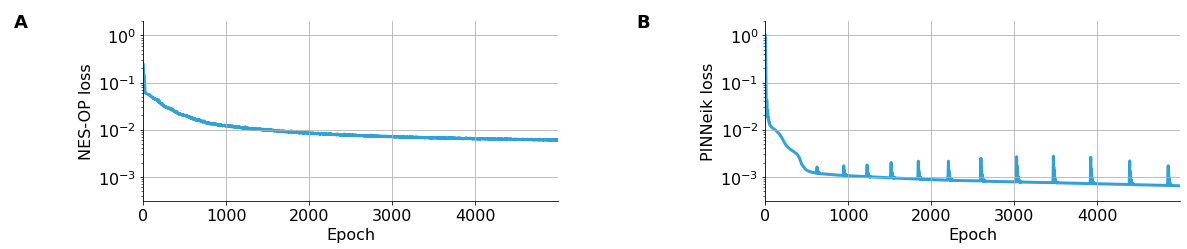

In [ ]:
figs = [hv.Curve(NES_loss).opts(ylabel='NES-OP loss'), 
        hv.Curve(PINNeik_loss).opts(ylabel='PINNeik loss')]
fig = hv.Layout(figs).cols(2).opts(hv.opts.Curve(logy=True, show_grid=True, 
                                                 linewidth=3,
                                                 xlabel='Epoch', fig_size=250, 
                                                 fontsize=dict(labels=16, ticks=16, 
                                                               title=18)))
fig.opts(fig_size=200)

## Solution contours

:Overlay
   .Image.I                      :Image   [X (km),Z (km)]   (Velocity (km/s))
   .Contours.FMM                 :Contours   [x,y]   (Time (s))
   .Contours.NES_hyphen_minus_OP :Contours   [x,y]   (Time (s))
   .Contours.PINNeik             :Contours   [x,y]   (Time (s))
   .Scatter.I                    :Scatter   [x]   (y)
   .Curve.FMM                    :Curve   [x]   (y)
   .Curve.NES_hyphen_minus_OP    :Curve   [x]   (y)
   .Curve.PINNeik                :Curve   [x]   (y)
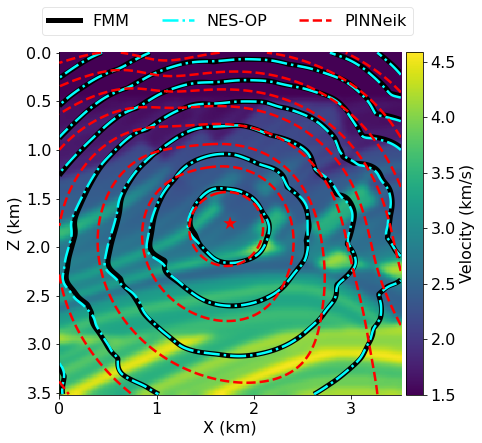

In [ ]:
vmap = hv.Image((x, z, V.T), vdims='Velocity (km/s)', 
                kdims=['X (km)', 'Z (km)']).opts(cmap='viridis', colorbar=True)

solutions = [T_ref, T_nes, T_pinneik]
labels = ['f-FMM', 'NES-OP', 'PINNeik']
levels = np.linspace(0, np.nanmax(T_ref), 10)
colors = ['#000000', '#00FFFF', '#FF0000']
linestyles = ['solid', '-.', 'dashed']
linewidths = [5, 2.5, 2.5]
tmaps = [hv.Image((x, z, solutions[i].T), vdims='Time (s)', label=labels[i])
         for i in range(len(labels))]
contours = [hv.operation.contours(tmaps[i], levels=levels).opts(color=colors[i],
                                                        linestyle=linestyles[i], 
                                                        linewidth=linewidths[i]) 
            for i in range(len(tmaps))]

source_point = hv.Scatter((xs[0], xs[1])).opts(marker='*', s=200, c='r')

fig = hv.Overlay([vmap] + contours + [source_point])
fig = fig.opts(hv.opts.Image(fig_size=170, aspect=xmax/zmax, invert_yaxis=True))
fig = fig.opts(show_legend=True, 
               legend_opts=dict(loc=(-0.05, 1.05), ncol=3, framealpha=0.5),
               fontsize=dict(ticks=16, labels=16,legend=16))
fig